In [1]:
from pymoo.algorithms.nsga3_uip import NSGA3
from joblib import Parallel,delayed
from pymoo.factory import get_problem, get_crossover, get_mutation, get_performance_indicator, get_reference_directions
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.model.problem import Problem
import autograd.numpy as anp
import math
import time
import numpy as np
from pymoo.model.callback import Callback
from pymoo.util.normalization import normalize
from copy import deepcopy
        
class MyCallback(Callback):

    def __init__(self) -> None:
        super().__init__()
        self.data["f-values"] = []
        self.data["x-values"] = []
        self.data["c-values"] = []
        self.data["archive"] = []

    def notify(self, algorithm):
        self.data["f-values"] = algorithm.pop.get("F")
        self.data["x-values"] = algorithm.pop.get("X")
        self.data["c-values"] = algorithm.pop.get("CV")
        self.data["archive"].append(algorithm.pop)

In [2]:
# Set the problem to run
name = 'mw5'
problem = get_problem(name)

# Set the seed; n_gen is an arbitrarily high number of generations, algorithm will terminate before that on its own
seed = 1
n_gen=15000

# Set the SBX crossover and polynomial mutation parameters
crossover = get_crossover("real_sbx", prob=0.9, eta=20)
mutation = get_mutation("real_pm", prob=1/problem.n_var, eta=20)

# Set the reference-vectors using the Das & Dennis method
if problem.n_obj==2:
    ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=99)
elif problem.n_obj==3:
    ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=13)

# Instantiate the algorithm object
algorithm = NSGA3(
    pop_size=len(ref_dirs), # population size same as the number of reference-vectors
    ref_dirs=ref_dirs, 
    crossover=crossover, 
    mutation=mutation, 
    eliminate_duplicates=True
)

# Execute the optimization
res = minimize(
    problem, 
    algorithm, 
    ('n_gen', n_gen), 
    seed=seed, 
    callback=MyCallback(), 
    verbose=False
)

# Save the data
for key in ["f-values", "c-values", "x-values"]:
    df = np.array(res.algorithm.callback.data[key])
    np.save("data/"+name+'-'+key+'-'+str(seed)+'.npy', df)


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.configuration import Configuration
Configuration.show_compile_hint = False

Generation: 100
mild stabilization has reached at gen: 168
Generation: 200
Generation: 300
Generation: 400
Generation: 500
Generation: 600
Generation: 700
Generation: 800
Generation: 900
Generation: 1000
Generation: 1100
intermediate stabilization has reached at gen: 1188
Generation: 1200
Generation: 1300
Generation: 1400
Generation: 1500
Generation: 1600
Generation: 1700
Generation: 1800
Generation: 1900
strict stabilization has reached at gen: 1983


Text(0, 0.5, '$f_2$')

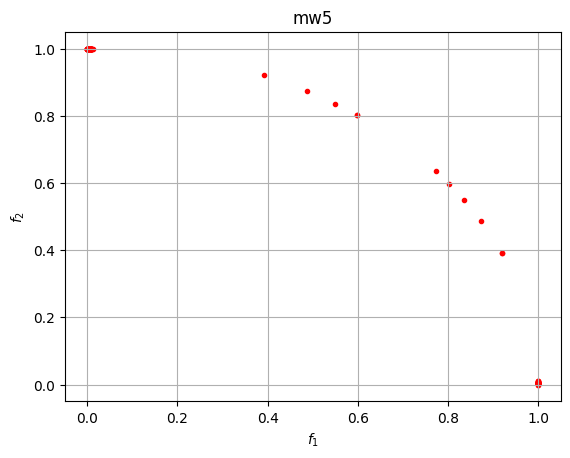

In [13]:
# Plot the obtained front

import matplotlib.pyplot as plt

df = np.load("data/"+name+'-f-values-'+str(seed)+'.npy')

plt.scatter(df[:, 0], df[:, 1], marker = '.', color = 'red')

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.grid()
plt.title(name)
plt.xlabel('$f_1$')
plt.ylabel('$f_2$')